# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Jasleen | Badhesha | Jasleen Badhesha, November 8, 2024 | Hours | 25% |
| Member 2: | Negar | Raika | Negar Raika, November 8, 2024 | Hours | 25% |
| Member 3: | Ishpreet | Kapoor | Ishpreet Kapoor November 8, 2024| Hours | 25% |
| Member 4: | Deep | Patel | Deep Patel November 8, 2024 | Hours | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

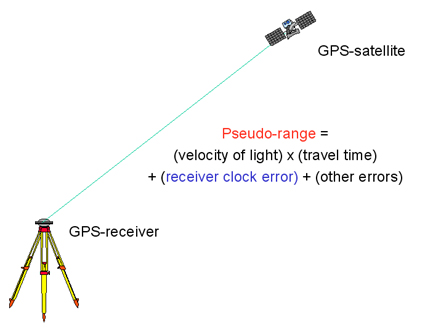

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [1107]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [1108]:
#mounting google drive so we can access the data files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 0.2: Read and parse data files

In [1109]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size
#to make sure the data is correctly loaded, we can print(n)
#print(n)

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [1110]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [1111]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [1112]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance

### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [1113]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    rho = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = rho + cdT
    residuals = pseudorange - predicted_pseudorange
    L = np.sum(residuals**2)/n
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [1114]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    grad = np.array([0.0,0.0,0.0,0.0])    # Initialize the gradient array

    rho = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = rho + cdT
    residuals = pseudorange - predicted_pseudorange


    for i in range(n):

        diff = r_pos - s_pos[i]
        distance = np.linalg.norm(diff)

        if distance > 0:
            # dL/dx_r
            grad[0] = grad[0] + 2 * residuals[i] * (-diff[0] / distance)
            # dL/dy_r
            grad[1] = grad[1] + 2 * residuals[i] * (-diff[1] / distance)
            # dL/dz_r
            grad[2] = grad[2] + 2 * residuals[i] * (-diff[2] / distance)

    # cdT
    grad[3] = -2 * np.sum(residuals)

    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [1115]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)
    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [1116]:
optimized_params = gradient_descent(pseudorange, sat_pos)

# print the mentioned metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)

final_position_error = optimized_params[:3] - GroundTruth
print("Final Position Error:", final_position_error)

print("Number of Steps Taken for Convergence:", steps_count)

final_cost = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
print("Final Cost Value:", final_cost)

final_gradient = gradient(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
print("Final Gradient Values:", final_gradient)

Converged !
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44954762e+00]
Final Position Error: [-3.06252556 -2.346982    3.77353113]
Number of Steps Taken for Convergence: 2700
Final Cost Value: 0.563436913173813
Final Gradient Values: [ 0.00161511  0.00899931 -0.02765869 -0.0156805 ]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

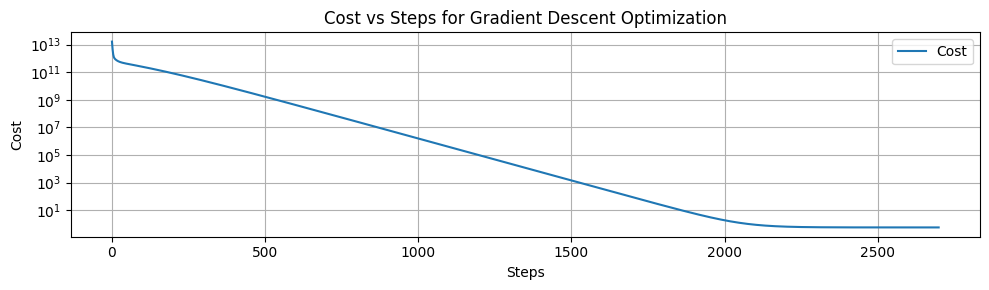

In [1117]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
#

ax.semilogy(arr_cost, label='Cost')



ax.set_xlabel('Steps')
ax.set_ylabel('Cost')
ax.set_title('Cost vs Steps for Gradient Descent Optimization')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

# Comment on the pattern
# There is a steep decrease in the cost for the initial ~10-20 steps. This shows that the gradient descent is very efficient at the start.
# From steps 20-2000, the cost linearly decreases as the steps increase, until the figure starts to converge to the global minimum around 2000 th steps and the curve flattens.


### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

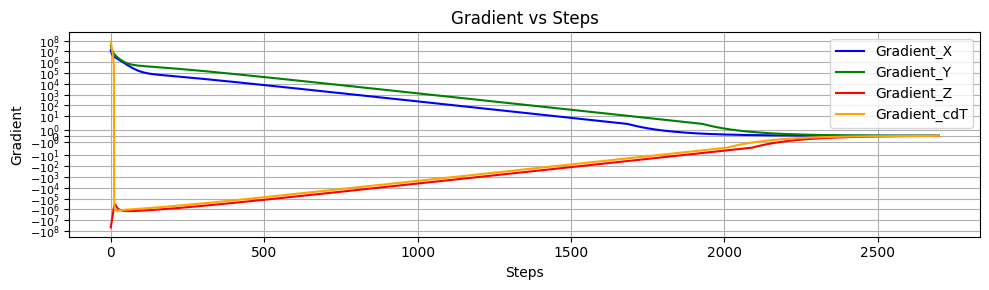

In [1118]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# ...

df= pd.DataFrame(arr_grad, columns=['Gradient_x', 'Gradient_y', 'Gradient_z', 'Gradient_cdT'])

ax.plot(df["Gradient_x"], label='Gradient_X', color='blue')
ax.plot(df["Gradient_y"], label='Gradient_Y', color='green')
ax.plot(df["Gradient_z"], label='Gradient_Z', color='red')
ax.plot(df["Gradient_cdT"], label='Gradient_cdT', color='orange')

ax.set_yscale('symlog')
ax.tick_params(axis='y', labelsize=8)

ax.set_xlabel('Steps')
ax.set_ylabel('Gradient')
ax.set_title('Gradient vs Steps')

plt.legend()

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The plot shows a gradient descent process converging towards a solution.
# The varying initial values and convergence rates suggest differences in the optimization landscape along different dimensions.
# There is a steep decrease in the gradient for all parameters in the first ~10 iterations
# This indicates that the algorithm is working efficiently and adjusting the parameters rapidly in the direction of steepest descent.
# After these initial steps, there is a linear decrease in the gradient magnitude as the iterations increase.
# The gradients are approaching zero, indicating the algorithm is nearing the optimal solution.


### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

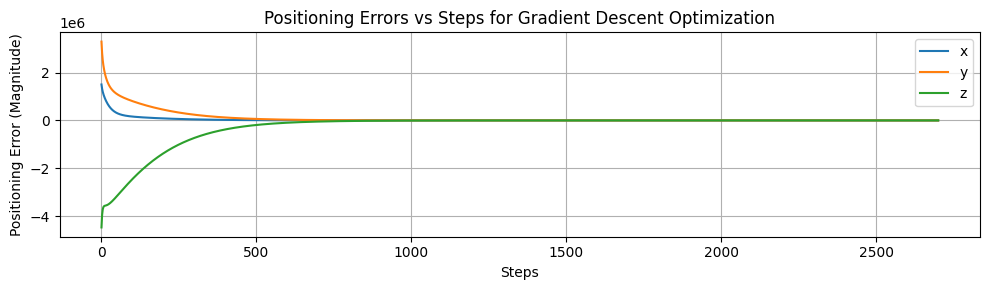

In [1119]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
# ...


ax.plot(arr_err)

ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Error (Magnitude)')
ax.set_title('Positioning Errors vs Steps for Gradient Descent Optimization')

ax.grid(True)
fig.tight_layout()
plt.legend(['x','y','z'])

plt.show()

# Comment on the pattern
#The positioning errors initially were significant but gradually diminish as the algorithm progresses.
# This convergence towards zero or near-zero errors indicates the receiver's position estimate is becoming increasingly accurate.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [1120]:
#set learning rate to 0.01
learning_rate_2 =  0.01

#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate_2)

# print the metrics
#
final_position_error_2 = optimized_params_2[:3] - GroundTruth
final_cost_2 = cost_function(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)
final_gradient_2 = gradient(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)

print("Optimized Parameters (x_r, y_r, z_r, cdT) with Learning Rate 0.01:", optimized_params_2)
print("Final Position Error:", final_position_error_2)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_2)
print("Final Gradient Values:", final_gradient_2)

Converged !
Optimized Parameters (x_r, y_r, z_r, cdT) with Learning Rate 0.01: [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44954762e+00]
Final Position Error: [-3.06252556 -2.346982    3.77353113]
Number of Steps Taken for Convergence: 2700
Final Cost Value: 0.563436913173813
Final Gradient Values: [ 0.00161511  0.00899931 -0.02765869 -0.0156805 ]


In [1121]:
#set learning rate to 0.001
learning_rate_3 = 0.001

#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate_3, max_iters=100000)

# print the metrics
# ...
final_position_error_3 = optimized_params_3[:3] - GroundTruth
final_cost_3 = cost_function(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)
final_gradient_3 = gradient(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)

print("Optimized Parameters (x_r, y_r, z_r, cdT) with Learning Rate 0.001:", optimized_params_3)
print("Final Position Error:", final_position_error_3)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_3)
print("Final Gradient Values:", final_gradient_3)

Converged !
Optimized Parameters (x_r, y_r, z_r, cdT) with Learning Rate 0.001: [-1.63349244e+06 -3.65162950e+06  4.95248531e+06  6.40077571e+00]
Final Position Error: [-3.05750202 -2.31899094  3.68750284]
Number of Steps Taken for Convergence: 25431
Final Cost Value: 0.5640823040356191
Final Gradient Values: [ 0.00512133  0.02853587 -0.08770273 -0.04972126]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

With a learning rate of 0.01, the gradient descent reached a solution in fewer steps, but as the steps were bigger it is probably not as precise as they could have missed the exact best point. Compared to a learning rate of 0.001, the algorithm took smaller steps, which required more steps to get to the solution but resulted in a more stable final position error. Higher learning rate can make things faster but might not be as exact, while a smaller learning rate is slower but can be more accurate.

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)

LSE is a method to find the best-fit parameters in a single calculation by minimizing the sum of squared differences between observed and predicted values. It is a fast and direct method, but is not flexible for complex or non-linear problems.
Gradient Descent is a step-by-step method that can handle more complex and non-linear problems. It is an iterative algorithm that works by gradually adjusting the parameters to lower the error (based on the learning rate) in small steps to minimize the cost function. We used Gradient Descent as it is used for complex models where direct computation is not feasible and because the problem is non-linear, LSE wouldn't work as well.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [1122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [1123]:
!pip install ucimlrepo

In [1124]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# data (as pandas dataframes)
X = phishing_websites.data.features
y = phishing_websites.data.targets

# TO DO: display sizes of X and y (1 mark)
print("Size of X:", X.shape)
print("Size of y:", y.shape)

Size of X: (11055, 30)
Size of y: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

result
 1        6157
-1        4898
Name: count, dtype: int64
[6157 4898]


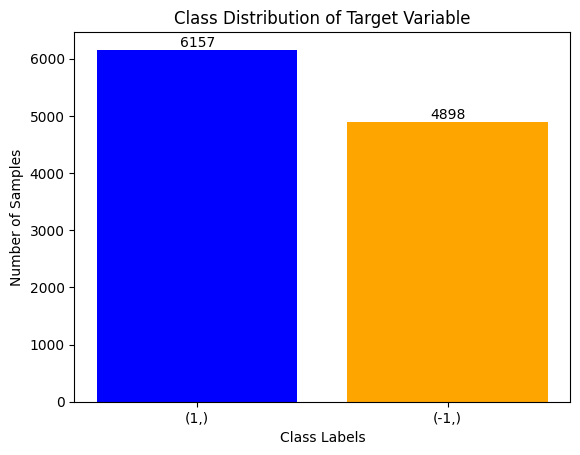

In [1125]:
# TO DO: Check the class distribution of y (2 mark)
class_counts = y.value_counts()
print(class_counts)
print(class_counts.values)

# Convert index to strings for plotting on x-axis
# This addresses the TypeError issue by providing a suitable data type for the x-axis
plt.bar([str(i) for i in class_counts.index], class_counts.values, color=['blue', 'orange'])
for idx, value in enumerate(class_counts.values):
  plt.text(str(class_counts.index[idx]), value, str(value), ha='center', va='bottom')

# Display exact values for each bin in the histogram
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.title("Class Distribution of Target Variable")
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [1126]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.03, random_state=42, stratify=y)

# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)

Size of X_small: (331, 30)
Size of y_small: (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [1127]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=2000)
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report
def evaluate_model(X, y):
    # Split the data into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.3, random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)

    # Calculate metrics
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    log_loss_value = log_loss(y_test, y_test_prob)

    # Gather results
    results = {
        "data_size": len(X),
        "training_samples": len(X_train),
        "testing_samples": len(X_test),
        "training_accuracy": training_accuracy,
        "testing_accuracy": testing_accuracy,
        "log_loss": log_loss_value
    }

    return results

results_full = evaluate_model(X, y)
results_first_two = evaluate_model(X.iloc[:, :2], y)
results_small = evaluate_model(X_small, y_small)
results_df = pd.DataFrame({
    "Data size": [results_full['data_size'], results_first_two['data_size'], results_small['data_size']],
    "Training samples": [results_full['training_samples'], results_first_two['training_samples'], results_small['training_samples']],
    "Testing samples": [results_full['testing_samples'], results_first_two['testing_samples'], results_small['testing_samples']],
    "Training accuracy": [results_full['training_accuracy'], results_first_two['training_accuracy'], results_small['training_accuracy']],
    "Testing accuracy": [results_full['testing_accuracy'], results_first_two['testing_accuracy'], results_small['testing_accuracy']],
    "Log loss": [results_full['log_loss'], results_first_two['log_loss'], results_small['log_loss']],
}, index=["Full dataset", "First two columns", "Smaller dataset"])
print(results_df)

                   Data size  Training samples  Testing samples  \
Full dataset           11055              7738             3317   
First two columns      11055              7738             3317   
Smaller dataset          331               231              100   

                   Training accuracy  Testing accuracy  Log loss  
Full dataset                0.932282          0.922822  0.190326  
First two columns           0.562807          0.556828  0.683573  
Smaller dataset             0.930736          0.890000  0.278789  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [1128]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y.values.ravel(), test_size=0.3, random_state=0)
model.fit(X_train_full, y_train_full)
y_test_full_pred = model.predict(X_test_full)

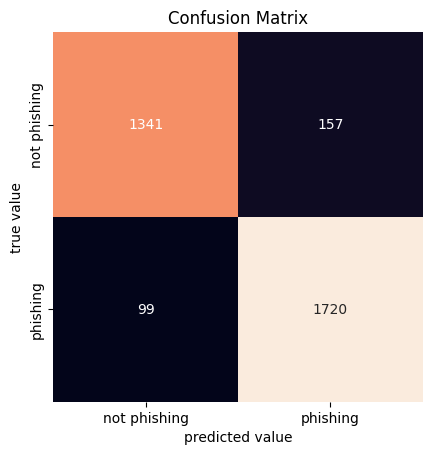

In [1129]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test_full, y_test_full_pred)
# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.title('Confusion Matrix')
plt.show()

In [1130]:
# TO DO: Print classification report (2 marks)
print(classification_report(y_test_full, y_test_full_pred))

              precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)

- There is an approximate 55/45 split, indicating that the dataset is relatively balanced. A balanced data set should not affect model performance.

2. Does the model overfit or underfit for each of the 3 cases? (3 marks)

  Case 1: Full dataset
  - In this case, the model adaquately fit the data because the training and test models both had a similar accuracy (92 and 93% respectively)
  
  Case 2: First 2 columns
  - In this case, the model is underfitting the data because both the training and test sets had a low accuracy (around 55% for each).
  
  Case 3: Smaller dataset
  - In this case, the model is overfitting the data. This can be determined becasue the model performed relatively well on the training set (93% accuracy)but did worse on the test set (89% accuracy).

3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)

- When the dataset is larger there are more data points and parameters for the model to train on, it gives better accuracy like in the case of first dataset in step 3. The training and testing accuracy increases and the gap between the two accuracies decreases (93% vs 92% resp.). However, because the traning dataset is always a larger portion of the data, this accuracy will be higher than the testing accuracy in most cases.
- If the training dataset was small (say 10%) but with as many paramerters to train on, the model would memorize this data and have a higher training accuracy, but a relatively lower test accuracy because it doesn't really know how to fit the data adequately because of the lack of the variety in the dataset. Like in the case of small dataset in step 3 (93% vs 89% resp.)
-When the number of parameters decreses there are not as many labels available to train our model on and the data is not as nuanced. Therefore the model does not fit the curve as good as it should be thereby giving low prediction accuracy in both training and testing data. Like in the second dataset of step 3 with just two columns. (56% vs 55%)
- As the dataset used for the training purposes increases (say up to 80 % of the data), the training accuracy may decrease (down to 90%) but the test accuracy would increase, and eventually be very similar to the training accuracy (also up to 90%).

4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
- A false positive is indicating that a webpage has been falsely flaged as a phishing webpage by the model which in reality is not a phish.
- A false negative is model predicting the webpage is not a phish when it is a phish in reality.
- A false negative would be worse because you are exposed to the phishing webpage as it was not filtered out proving to be dangerous than the option otherwise.

5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)

- We would want to maximize recall because it is more important to catch the false negatives, since we do not want to misclassify a phishing email.
Recall is calculated by dividing the correctly classified actual positives by the total number of positives classified (whether correctly or incorrectly identified). A recall close to 1 would indicate that the model is effectively classifying emails as true positives (is a phish and is sorted as a phish).  

6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 marks)

  Case 1: Full dataset
  - Log loss measures the difference between a predicted and observed value as the logrithmic magnitude and a smaller log loss value indicates that the model is performing well. The log loss calculated from the full dataset has the smallest value of all 3 cases. This indicates that this model is the most accurate as the predicted values from the model are fitting the labelled data.

  Case 2: First 2 columns
  - The log loss for this case is the highest of all 3 cases. This indiacates that there is a large discrepency between the predicted and observed values generated by the model, as is the worst performing of the 3.  

  Case 3: Smaller dataset
  - The log loss for this case is higher than the one calculated for the full dataset, but smaller than the 2 columns dataset. At a value of 0.27, the model is still performing relatiely well.

  The most likely cause for these differences is the size of the dataset. Larger datasets give the model more opportunities to learn the patterns within the data. With a smaller dataset, the model does not have the same opportunities and may underfit the data if it misses key relationship, or overfits the data if it ends up memorizing all the of data points.

---
---